## Dataloaders for Machine Learning (Tensorflow & PyTorch)

This tutorial acts as a step by step guide for fetching, preprocessing, storing and loading the [MS-COCO](http://cocodataset.org/#home) dataset for image captioning using deep learning. We have chosen **image captioning** for this tutorial not by accident. For such an application, the dataset required will have both fixed shape (image) and variably shaped (caption because it's sequence of natural language) data. This diversity should help the user to get a mental model about how flexible and easy is to plug hangar to the existing workflow.

You will use the MS-COCO dataset to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations.

This tutorial assumes you have downloaded and extracted the [MS-COCO dataset](http://cocodataset.org/#home) in the current directory. If you haven't below shell commands should help you do it (beware, it's about 14 GB data). If you are on Windows, please find the equivalent commands to get the dataset downloaded.


```bash
wget http://images.cocodataset.org/zips/train2014.zip
unzip train2014.zip
rm train2014.zip
wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
unzip annotations_trainval2014.zip
rm annotations_trainval2014.zip
```

Let's install the required packages in our environment. We will be using tensorflow 1.14 in this tutorial but it should work in all the tensorflow versions starting from 1.12. But do let us know if you face any hiccups. Install below-given packages before continue. Apart from tensorflow and hangar, we use [SpaCy](https://spacy.io/) for pre-processing the captions. SpaCy is probably the most wildly used natural language toolkit now.

```bash
tensorflow==1.14.0
hangar==3.0
spacy==2.1.8
```

One more thing before jumping into the tutorial; We need to download the SpaCy English model `en_core_web_md` which cannot be dynamically loaded. Which means, it must be downloaded with the below command outside this runtime and should reload this runtime.

```bash
python -m spacy download en_core_web_md
```

Once all the dependencies are installed and loaded, we can start building our hangar repository


### Hangar Repository creation and arrayset init
We will create a repository and initialize one arrayset named `images` now for a quick demo of how tensorflow dataloader work. Then we wipe the current repository and create new arraysets for later portions

In [ ]:
repo_path = 'hangar_repo'
username = 'hhsecond'
email = 'sherin@tensorwerk.com'
img_shape = (299, 299, 3)
image_dir = '/content/drive/My Drive/train2014'
annotation_file = ''
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

In [2]:
import os
from hangar import Repository
import tensorflow as tf
import numpy as np

tf.compat.v1.enable_eager_execution()


if not os.path.isdir(repo_path):
    os.mkdir(repo_path)

repo = Repository(repo_path)
repo.init(user_name=username, user_email=email, remove_old=True)
co = repo.checkout(write=True)

images_aset = co.arraysets.init_arrayset('images', shape=img_shape, dtype=np.uint8, named_samples=False)
co.commit('arrayset init')
co.close()

Hangar Repo initialized at: hangar_repo/.hangar


### Add sample images
Here we add few images to the repository and show how we can load this data as tensorflow dataloader. We use the idea we learn here in the later portions to build a fully fledged training loop

In [ ]:
import os
from PIL import Image


co = repo.checkout(write=True)
images_aset = co.arraysets['images']
try:
    for i, file in enumerate(os.listdir(image_dir)):
        pil_img = Image.open(os.path.join(image_dir, file))
        if pil_img.mode == 'L':
            pil_img = pil_img.convert('RGB')
        img = pil_img.resize(img_shape[:-1])         
        img = np.array(img)
        images_aset[i] = img
        if i != 0 and i % 2 == 0:  # stopping at 2th image
            break
except Exception as e:
    print('Exception', e)
    co.close()
    raise e
co.commit('added image')
co.close()

### Let's make a tensorflow dataloader
Hangar provides `make_tf_dataset` & `make_torch_dataset` for creating tensorflow & pytorch datasets from hangar arraysets. You can read more about it in the [documentation](https://hangar-py.readthedocs.io/en/latest/api.html#ml-framework-dataloaders). Next we'll make a tensorflow dataset and loop over it to make sure we have got a proper tensorflow dataset

In [ ]:
from hangar import make_tf_dataset

 * Checking out BRANCH: master with current HEAD: b769f6d49a7dbb3dcd4f7c6e1c2a32696fd4128f
<class 'hangar.arrayset.ArraysetDataReader'>(repo_pth=hangar_repo/.hangar, aset_name=images, default_schema_hash=b6edf0320f20, isVar=False, varMaxShape=(299, 299, 3), varDtypeNum=2, mode=r)


/usr/local/lib/python3.6/dist-packages/hangar/dataloaders/tfloader.py:88: UserWarning: Dataloaders are experimental in the current release.
  warnings.warn("Dataloaders are experimental in the current release.", UserWarning)


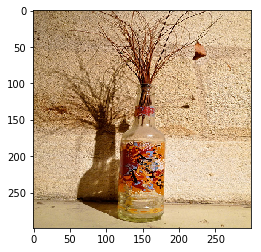

In [5]:
from matplotlib.pyplot import imshow
co = repo.checkout()
image_aset = co.arraysets['images']
dataset = make_tf_dataset(image_aset)
for image in dataset:
    imshow(image[0].numpy())
    break

### New arraysets

For our example, we would need two arraysets. One for the image and another one for captions. Let's wipe our existing repository (`remove_old` argument in `repo.init` does this) and create these arraysets

In [6]:
repo = Repository(repo_path)
repo.init(user_name=username, user_email=email, remove_old=True)
co = repo.checkout(write=True)

images_aset = co.arraysets.init_arrayset('images', shape=img_shape, dtype=np.uint8, named_samples=False)
captions_aset = co.arraysets.init_arrayset(name='captions', shape=(60,), dtype=np.float, variable_shape=True, named_samples=False)
co.commit('arrayset init')
co.close()

Hangar Repo initialized at: hangar_repo/.hangar


### Store image and captions to hangar repo
Each image will be converted to RGB channels with dtype uint8. Each caption will be prepended with `START` token and append with `END` token before converting them to floats. We have another preprocessing stage for images later

We'll start with loading the caption file

In [ ]:
import json
annotation_file = 'annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [ ]:
import spacy
# if you have installed spacy and the model in the same notebook session, you might need to restart the runtime to get it into the scope
nlp = spacy.load('en_core_web_md')

In [ ]:
def sent2index(sent):
    """
    Convert sentence to an array of indices using SpaCy
    """
    ids = []
    doc = nlp(sent)
    for token in doc:
        if token.has_vector:
            id = nlp.vocab.vectors.key2row[token.norm]
        else:
            id = sent2index('UNK')[0]
        ids.append(id)
    return ids

### Save the data to hangar

In [10]:
import os
from tqdm import tqdm

all_captions = []
all_img_name_vector = []
limit = 100  # if you are not planning to save the whole dataset to hangar. Zero means whole dataset

co = repo.checkout(write=True)
images_aset = co.arraysets['images']
captions_aset = co.arraysets['captions']
all_files = set(os.listdir(image_dir))
i = 0
with images_aset, captions_aset:
    for annot in tqdm(annotations['annotations']):
        if limit and i > limit:
            continue
        image_id = annot['image_id']
        assumed_image_paths = 'COCO_train2014_' + '%012d.jpg' % (image_id)
        if assumed_image_paths not in all_files:
            continue
        img_path = os.path.join(image_dir, assumed_image_paths)
        img = Image.open(img_path)
        if img.mode == 'L':
            img = img.convert('RGB')
        img = img.resize(img_shape[:-1])         
        img = np.array(img)
        cap = sent2index('sos ' + annot['caption'] + ' eos')
        cap = np.array(cap, dtype=np.float)
        co.arraysets.multi_add({
            images_aset.name: img,
            captions_aset.name: cap
        })
        if i % 1000 == 0 and i != 0:
            if co.diff.status() == 'DIRTY':
                co.commit(f'Added batch {i}')
        i += 1
co.commit('Added full data')
co.close()

100%|██████████| 414113/414113 [00:03<00:00, 122039.19it/s]


### Preprocess Images

Our image captioning network requires a pre-processed input. We use transfer learning for this with a pretrained InceptionV3 network which is available in Keras. But we have a problem. Preprocessing is costly and we don't want to do it all the time. Since Hangar is flexible enough to create multiple arraysets and let you call the group of arrayset as a `dataset`, it is quite easy to do make a new arrayset for the processed image and we don't have to do the preprocessing online but keep a preprocessed image in the new arrayset in the same repository with the same key. Which means, we have three arraysets in our repository (all three has different samples with the same name)
- images
- captions
- processed_images

Although we need only the processed_images for the network, we still keep the bare image in the repository in case we need to look into it later or if we decided to do some other preprocessing instead of InceptionV3 (It is always advised to keep the source truth with you).



In [ ]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)


def process_image(img):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    img = image_features_extract_model(img)
    return tf.reshape(img, (-1, img.shape[3]))


In [ ]:
from hangar import Repository
import numpy as np

repo_path = 'hangar_repo'

repo = Repository(repo_path)
co = repo.checkout(write=True)
images = co.arraysets['images']
sample_name = list(images.keys())[0]
prototype = process_image(images[sample_name]).numpy()
pimages = co.arraysets.init_arrayset('processed_images', prototype=prototype)

#### Saving the pre processed image to the new arrayset

In [6]:
from tqdm import tqdm

with pimages:
    for key in tqdm(images):
        pimages[key] = process_image(images[key]).numpy()
        
co.commit('processed image saved')
co.close()

100%|██████████| 101/101 [00:11<00:00,  8.44it/s]


### Dataloaders for training
We are using Tensorflow to build the network but how do we load this data from hangar repository to tensorflow. A naive option is to run through the samples and load the numpy arrays and pass that to the `sess.run` of tensorflow. But that is quite inefficient. Tensorflow uses multiple threads to load the data to memory and its dataloaders can prefetch the data before-hand so that your training loop doesn't get blocked for loading the data. Also, tensoflow dataloader brings batching, shuffling, etc to the table prebuilt. That's cool but how to load data from hangar to tensorflow using TF dataset? Well, we have `make_tf_dataset` which accepts the list of arraysets as a parameter and returns a TF dataset object

In [7]:
from hangar import make_tf_dataset
co = repo.checkout()  # we don't need write checkout here

 * Checking out BRANCH: master with current HEAD: 3cbb3fbe7eb0e056ff97e75f41d26303916ef686


In [8]:
BATCH_SIZE = 1
EPOCHS = 2
embedding_dim = 256
units = 512
vocab_size = len(nlp.vocab.vectors.key2row)
num_steps = 50


captions_dset = co.arraysets['captions']
pimages_dset = co.arraysets['processed_images']

dataset = make_tf_dataset([pimages_dset, captions_dset], shuffle=True)

<class 'hangar.arrayset.ArraysetDataReader'>(repo_pth=hangar_repo/.hangar, aset_name=processed_images, default_schema_hash=f230548212ab, isVar=False, varMaxShape=(64, 2048), varDtypeNum=11, mode=r)
<class 'hangar.arrayset.ArraysetDataReader'>(repo_pth=hangar_repo/.hangar, aset_name=captions, default_schema_hash=4d60751421d5, isVar=True, varMaxShape=(60,), varDtypeNum=12, mode=r)


/usr/local/lib/python3.6/dist-packages/hangar/dataloaders/tfloader.py:88: UserWarning: Dataloaders are experimental in the current release.
  warnings.warn("Dataloaders are experimental in the current release.", UserWarning)


### Padded Batching

Batching needs a bit more explanation here since the dataset does not just consist of fixed shaped data. We have two dataset in which one is for captions. As you know captions are sequence = variably shaped. So instead of using `dataset.batch` we need to use `dataset.padded_batch` which takes care of padding the tensors with the longest value in each dimension for each batch. This `padded_batch` needs the shape by which the user needs the batch to be padded. Unless you need customization, you can use the shape stored in the `dataset` object by `make_tf_dataset` function

In [9]:
output_shapes = tf.compat.v1.data.get_output_shapes(dataset)
output_shapes

(TensorShape([Dimension(64), Dimension(2048)]), TensorShape([Dimension(None)]))

In [ ]:
dataset = dataset.padded_batch(BATCH_SIZE, padded_shapes=output_shapes)

### Build the network

So have the dataloaders ready. Now let's build the network for image captioning and start training. Rest of this tutorial is a copy of an official tensorflow tutorial which is available at https://tensorflow.org/beta/tutorials/text/image_captioning. The content of tensorflow tutorial page is licensed under the Creative Commons Attribution 4.0 License, and code samples are licensed under the Apache 2.0 License.
Access date: Aug 20 2019


In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048) and quash that to a shape of (64, 2048). We have stored the result of this already to our hangar repo. This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer). The RNN (here GRU) attends over the image to predict the next word.

In [ ]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        # hidden shape == (batch_size, hidden_size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # score shape == (batch_size, 64, hidden_size)
        score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # attention_weights shape == (batch_size, 64, 1)
        # you get 1 at the last axis because you are applying score to self.V
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)
        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)
        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)
        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder.reset_state(batch_size=target.shape[0])
    # TODO: do this dynamically: '<start>' == 2
    dec_input = tf.expand_dims([2] * BATCH_SIZE, 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
    total_loss = (loss / int(target.shape[1]))
    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))
    return loss, total_loss

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

### Training

Here we consume the dataset we have made before by looping over it. The dataset returns the image tensor and target tensor (captions) which we will pass to `train_step` for training the network

The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder. The decoder returns the predictions and the decoder hidden state. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss. Use teacher forcing to decide the next input to the decoder. Teacher forcing is the technique where the target word is passed as the next input to the decoder. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [ ]:
import time

loss_plot = []

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        if batch % 1 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch and loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss / num_steps))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


#### Visualize the loss

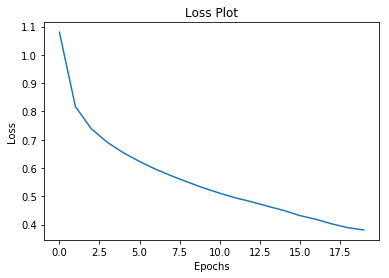

In [23]:
import matplotlib.pyplot as plt
# Below loss curve is not the actual loss image we have got
# while training and kept it here only as a reference
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()